In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ipywidgets import interact, IntSlider

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [3]:
df_range = (
    pd.read_csv('saprc99_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
C_O2,5.391452e+06,1.419437e+09,7.124145e+08,1.414046e+09
BZCO_O2,1.000000e-08,3.226580e+06,1.613290e+06,3.226580e+06
RO2_R,2.006049e+05,1.824368e+09,9.122844e+08,1.824168e+09
NO,1.006610e+05,9.000156e+11,4.500078e+11,9.000155e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11,1.456161e+12
NO3,1.742790e+06,1.039629e+10,5.199017e+09,1.039455e+10
CCO_O2,6.779490e+05,5.267318e+08,2.637049e+08,5.260539e+08
RCO_O2,7.110903e+04,3.979400e+08,1.990056e+08,3.978689e+08
OH,9.784155e+04,7.272688e+07,3.641236e+07,7.262904e+07
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


# Make training data

In [4]:
shrink = 0.0

y0_list =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(20000, nvar+1))

y0_list.shape

(20000, 75)

In [5]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 20.3 s, sys: 4 ms, total: 20.3 s
Wall time: 20.2 s


(20000, 74)

# Normalize data

In [6]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(20000, 75)

In [8]:
Y_train = normalizer.transform(y1_list)

# Plot distribution before and after reaction

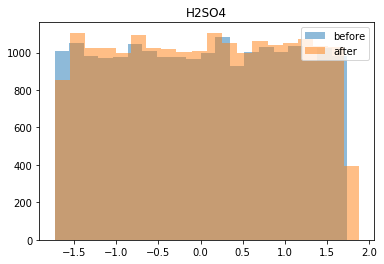

In [9]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(X_train[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(Y_train[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

# React one more step

In [10]:
%time y2_list = kpp.onestep(np.c_[y1_list, y0_list[:,-1:]].T).T  # use the same SUN as y0
y2_list.shape

CPU times: user 7.1 s, sys: 12 ms, total: 7.11 s
Wall time: 7.1 s


(20000, 74)

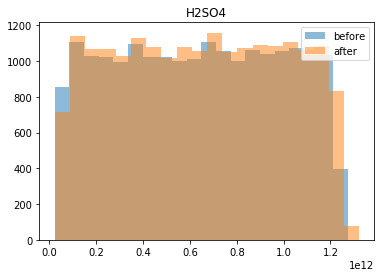

In [11]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(y1_list[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(y2_list[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

# Re-normalize data

In [12]:
normalizer = StandardScaler()
normalizer.fit(y1_list[:,0:74])

X_train = np.append(normalizer.transform(y1_list[:,0:74]), 
                    y0_list[:,-1:],  # use old SUN !
                    axis=1)
Y_train = normalizer.transform(y2_list)

# Fit ANN

In [13]:
#x_torch = Variable(torch.from_numpy(X_train))
#y_torch = Variable(torch.from_numpy(Y_train))

x_torch = Variable(torch.from_numpy(X_train)).type(torch.FloatTensor).cuda()
y_torch = Variable(torch.from_numpy(Y_train)).type(torch.FloatTensor).cuda()

In [14]:
H1, H2 = 200, 200

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 74)
).cuda()#double()

In [32]:
%%time
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for t in range(400):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

KeyboardInterrupt: 

In [33]:
y_pred = model(x_torch)
#y_pred_numpy = y_pred.data.numpy()
y_pred_numpy = y_pred.cpu().data.numpy()

In [34]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.99982854, 0.99973806, 0.99985822, 0.99985891, 0.99985497,
       0.99983587, 0.99977221, 0.99978342, 0.99981665, 0.99985824,
       0.99984868, 0.99910586, 0.99964864, 0.99957979, 0.99948851,
       0.99936039, 0.99974366, 0.99866998, 0.99772424, 0.99981249,
       0.99983175, 0.9983858 , 0.99965975, 0.99955247, 0.99916666,
       0.99965987, 0.99929178, 0.99863373, 0.9998019 , 0.99973997,
       0.99970218, 0.9985616 , 0.99725232, 0.99318468, 0.9993035 ,
       0.99839647, 0.99959036, 0.99949015, 0.99272103, 0.99986125,
       0.99932957, 0.99983886, 0.99984645, 0.99961079, 0.99911736,
       0.99872821, 0.994077  , 0.99942087, 0.9791728 , 0.99937133,
       0.99894738, 0.99826054, 0.98950528, 0.99934224, 0.99930194,
       0.99938328, 0.99966508, 0.99965382, 0.9992549 , 0.99978627,
       0.99951978, 0.99980835, 0.99959057, 0.99937832, 0.99933659,
       0.99975851, 0.99946544, 0.99968568, 0.99860505, 0.9997869 ,
       0.99865504, 0.99971107, 0.99959811, 0.99924139])

In [35]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9994011417345791

Text(0,0.5,'neural net prediction')

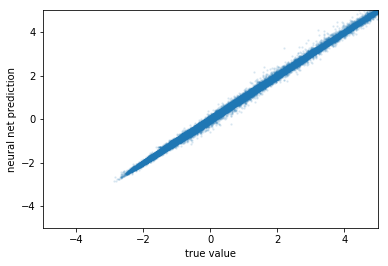

In [36]:
plt.scatter(y_pred_numpy, Y_train, alpha=0.1, s=2.0)
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel('true value')
plt.ylabel('neural net prediction')

# Test set

In [37]:
shrink = 0.0

y0_test = np.random.uniform(df_range['min'] + shrink*df_range['span'],
                           df_range['max'] - shrink*df_range['span'], 
                           size=(5000, nvar+1))

y0_test.shape

(5000, 75)

In [38]:
%%time 
y1_test = kpp.onestep(y0_test.T).T
y2_test = kpp.onestep(np.c_[y1_test, y0_test[:,-1:]].T).T  # use the same SUN as y0
y2_test.shape

CPU times: user 6.79 s, sys: 0 ns, total: 6.79 s
Wall time: 6.77 s


In [39]:
X_test = np.append(normalizer.transform(y1_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y2_test)

In [40]:
%%time
#X_torch_test = Variable(torch.from_numpy(X_test))
#y_test_pred = model(X_torch_test).data.numpy()
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor).cuda())
y_test_pred = model(X_torch_test).data.cpu().numpy()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.84 ms


In [41]:
r2_score(y_test_pred, Y_test, multioutput='variance_weighted')

0.9992073925467201

In [42]:
r2_score(y_test_pred, Y_test, multioutput='raw_values')

array([0.99979585, 0.99971092, 0.99982008, 0.99981298, 0.99983615,
       0.9998169 , 0.99973867, 0.99971793, 0.99977979, 0.99983909,
       0.99982073, 0.99897876, 0.99958686, 0.99945756, 0.99939701,
       0.99934077, 0.999713  , 0.99817027, 0.99702295, 0.9997918 ,
       0.99978164, 0.99816465, 0.99964313, 0.99950581, 0.99908154,
       0.99963389, 0.99915062, 0.99799396, 0.99975903, 0.99970856,
       0.99968069, 0.99827733, 0.99652296, 0.99162301, 0.99919769,
       0.99806804, 0.9995193 , 0.99942343, 0.99104056, 0.99982221,
       0.99928071, 0.99980418, 0.99982175, 0.99953044, 0.99892714,
       0.99799012, 0.99366428, 0.99910389, 0.95310719, 0.99926667,
       0.99874601, 0.99782315, 0.9853079 , 0.99920065, 0.99922967,
       0.99923232, 0.99964384, 0.99962184, 0.99917185, 0.99976458,
       0.99948741, 0.9997698 , 0.99954505, 0.99918563, 0.99886237,
       0.99968666, 0.99877033, 0.99960543, 0.99857071, 0.99976377,
       0.99787798, 0.99962347, 0.99938523, 0.99921744])

Text(0,0.5,'neural net prediction')

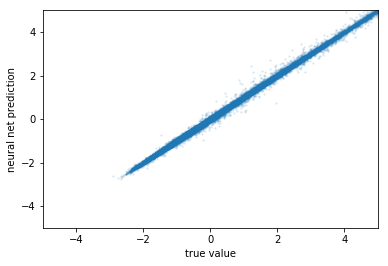

In [43]:
plt.scatter(y_test_pred, Y_test, alpha=0.1, s=2.0)
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel('true value')
plt.ylabel('neural net prediction')

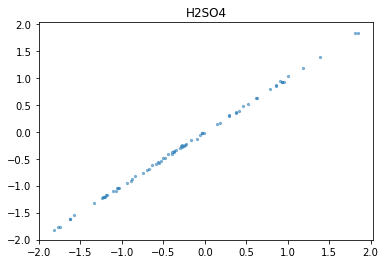

In [44]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_scatter(n):
    plt.scatter(y_test_pred[n,:], Y_test[n,:], 
                alpha=0.5, s=5.0)
    plt.title(varnames[n])

# Scale back to original concentration

In [45]:
y_test_pred_scale_back = normalizer.inverse_transform(y_test_pred)
y_test_scale_back = normalizer.inverse_transform(Y_test)

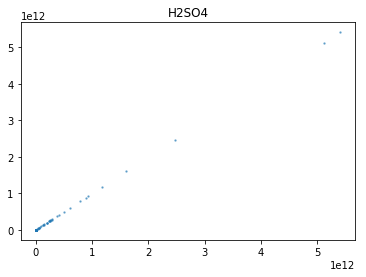

In [46]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_scatter(n):
    plt.scatter(y_test_pred_scale_back[n,:], 
                y_test_scale_back[n,:], 
                alpha=0.5, s=2.0)
    plt.title(varnames[n])